# Project overview
This notebook presents the core concepts developed during my thesis. The goal is to provide a high-level overview of the project and to explain the main ideas behind the code. The code itself is available in the `src` folder.

## Problem statement
The main goal of this project is to develop a method to solve the `path-planning` problem by taking inspiration on chemotaxis and the way bacteria move in their environment. The problem is defined as follows: given a starting configuration a goal configuration, find a path that connects the two configuration without intersecting any obstacle. The path should be as short as possible and should be found in a reasonable amount of time.

Furthermore, we want our method to have the following properties :
- to sample different paths from a given configuration
- to be able to cut through an obstacle if necessary
- to adapt to dynamic environments

This properties are required for the final application wich is surgical planning. In this context, the surgeon needs to be able to explore different paths from a given configuration with a quality mesure associated to it. Furthermore, the device should be able to make its way through an obstacle, as a bone or a muscle, if necessary. Finally, the method should handle incertainty on the obstacle positions since the surgeon can move obstacles during the surgery.

<img src="figures/cochlea.jpg" width=400 height=200 />
<figcaption>Figure 1 : From left to right, (a) an anatomical view of a cochlea with vestibular chamber and canals, (b) a cochlear implent with the array of electrodes (wire) and the digital signal processor (white box)</figcaption>

Our case study is the cochlear implent represented in Figure 1 (b) in which an array of electrodes is bring inside the cochlea (a) to stimulate the cochlear nerve. Therefore, we consider that our path-planning problem can be reduced to finding a collision-free path for the wire containing the electrodes inside a patient head. Furthermore, we consider that the wire can be approximated by a sequence of segments that apply a constraint on the head and that only the displacement of the head is of interest. Therefore, the model we use is a point robot moving in a 3D environment and containes 6 degree of freedom.

## Chemotaxis
Chemotaxis is the movement, observed in a wide range of organisms, indiced in response to a chemical stimulus. The stimulus can be either attractive or repulsive. We will only focus on the attractive case, in which the chemical stimulus is named chemoattractant. 

It is well known that bacteria use chemotaxis to find food (cf. Figure 2). The idea is that bacteria use the gradient of a chemoattractant to be guided toward the food. The gradient of the chemoattractant is computed by the bacteria and is used to control the direction of the movement. The movement is then a combination of a random walk and a directed movement. The random walk is used to explore the environment and the directed movement is used to move toward the food. The random walk is often  modeled by a Brownian motion and the directed movement is modeled by a drift term. The drift term is proportional to the gradient of the chemoattractant. The model is given by the following stochastic differential equation : 
$$dX_t = \sigma dB_t + \mu dt$$
where $X_t$ is the position of the bacteria at time $t$, $\sigma$ is the diffusion coefficient, $B_t$ is a Brownian motion and $\mu$ is the drift term. 

<img src="figures/E.colis.gif" class="center" width=400 height=200 />
<figcaption>Figure 2 : <i>E.Colis</i> bacteria moving toward a chemoattractant located in the left part of the screen.</figcaption> 

For the drift term not to be dependent of the local variation of concentration, it is shown that it can be described by :
$$\mu = \nabla \log C = \frac{\nabla C}{C}$$
where $C$ is the concentration of the chemoattractant. 

Finaly, we can estimate concentration of the chemoattractant at time $t$ by solving the heat equation : 
$$\partial_t C = D\Delta C$$
where $D$ is the diffusion coefficient of the process.

## Concentration field navigation
Using analogie with the chemotaxis study, the robot can be modeled as the organism and the chemical stimulus is the gradient of a scalar field based on the concentration distribution in the environment. The idea is to use the gradient of a scalar field to guide the robot toward a goal configuration. The scalar field is computed by solving the heat equation with a source term at the goal configuration and absorbing boundary condition on obstacles. The source term is a Dirac delta function and servesn as a source for the chemoatractant. The model is given by the following system of differential equation : 

$$\begin{cases} 
\partial_t C = D\Delta C + C_0\delta_{x_0} \\
C(x, 0) = C_0\delta_{x_0} \space \forall x \in \Omega \\
C(x, t) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$

In order to simplify the problem and to reduce the computational cost, we consider that the scalar field is constant in time (stationarity). Therefore, we can solve the following elliptic equation system instead of the previous one :
$$\begin{cases} 
- \Delta C = \frac{C_0}{D} \delta_{x_0} \\
C(x, 0) = C_0\delta_{x_0} \space \forall x \in \Omega \\
C(x, t) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$

## Python implementation
For a detailed introduction to the code, please refer to the `README.md` file in the `src` folder. The code is divided in 3 main parts :
- `envs` : contains the code for the creation of environements as subclass of gym.Env. It includes 2D and 3D environements with respectively random obstacles, maze, slots and obstacle-free environement.
- `taichi / phiflow` : contains the code for the numerical solver of the differential equations and the simulation of chemotactic walks with specialized libraries `taichi` or `phiflow`.
- `utils` : contains the code for the visualization of the scalar field and the path sampling.

In [20]:
%matplotlib inline
# Project imports
from snake_ai.envs import RandomObstaclesEnv, RoomEscape, SlotEnv, RandomObstacles3D, EnvConverter, Env3DConverter
from snake_ai.diffsim import DiffusionSolver, WalkerSimulationStoch2D, WalkerSimulationStoch3D
from snake_ai.diffsim.field import log, spatial_gradient
from snake_ai.utils.visualization import Visualizer
import snake_ai.utils.visualization as vis

# External imports
import taichi as ti
import numpy as np

### 2D exemples
Let first visualize 2D environement exemples with random obstacles and maze. The goal is represented by a green dot, the starting configuration by a blue dot and obstacles as red rectangles.

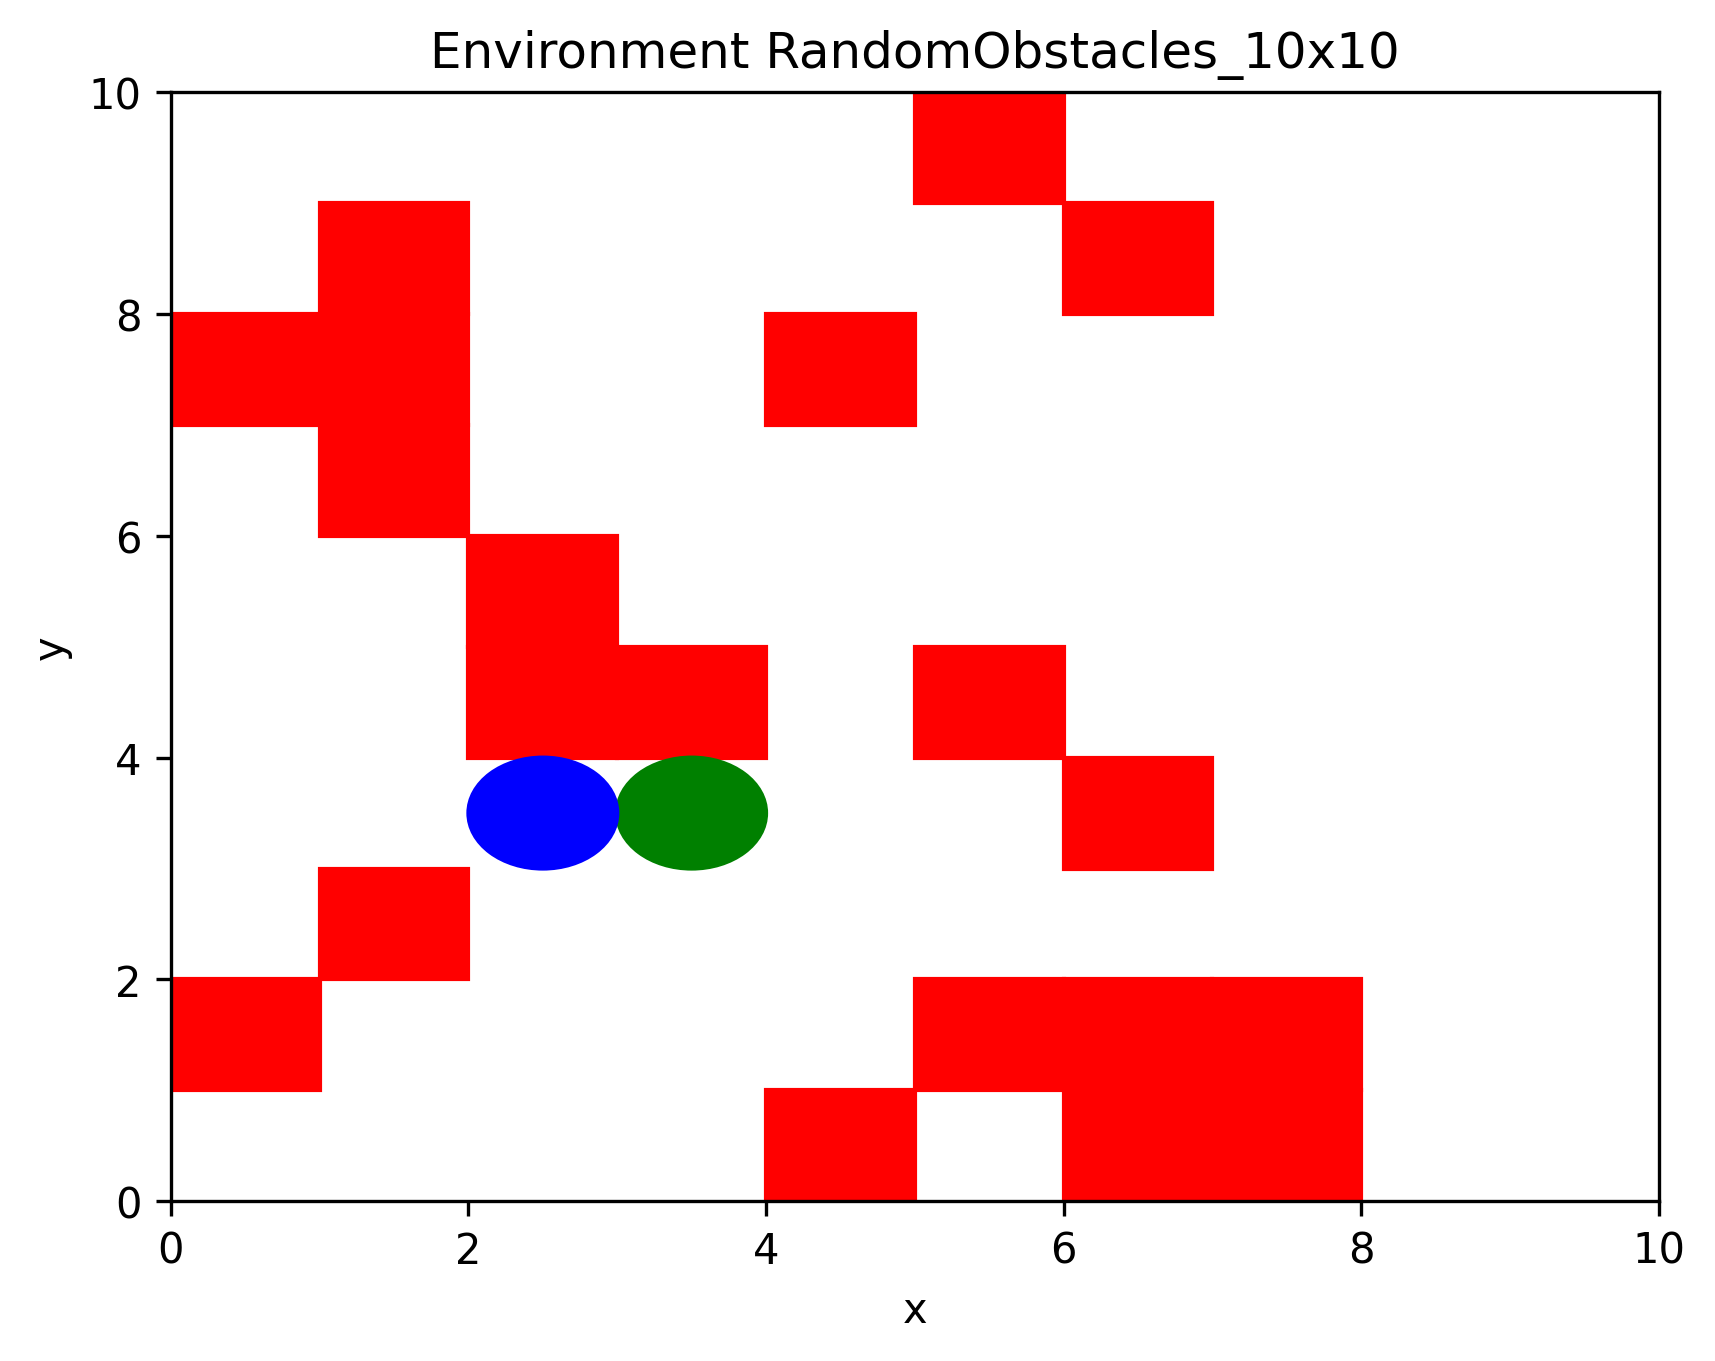

In [21]:
seed = 42
height, width = 10, 10
nb_obs, obs_size = 20, 1

env = RandomObstaclesEnv(height, width, pixel=1, nb_obs=nb_obs, max_obs_size=obs_size, seed=seed)
env.reset()
fig = vis.Visualizer.plot_2D_environment(env)

### Concentration estimation
We can then estimate a scalar field based on the concentration distribution in the environment as discribed in the [previous section](#concentration-field-navigation). The concentration is computed at stationarity with [Finite Difference Method](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter23.03-Finite-Difference-Method.html) by solving the inverse problem :
$$-[\Delta] C = b$$ 
where $[\Delta]$ is the discretized version of the Laplacian operator and $b$ is the source term with ones at the source position and zeros elsewhere.

[Taichi] Starting on arch=cuda


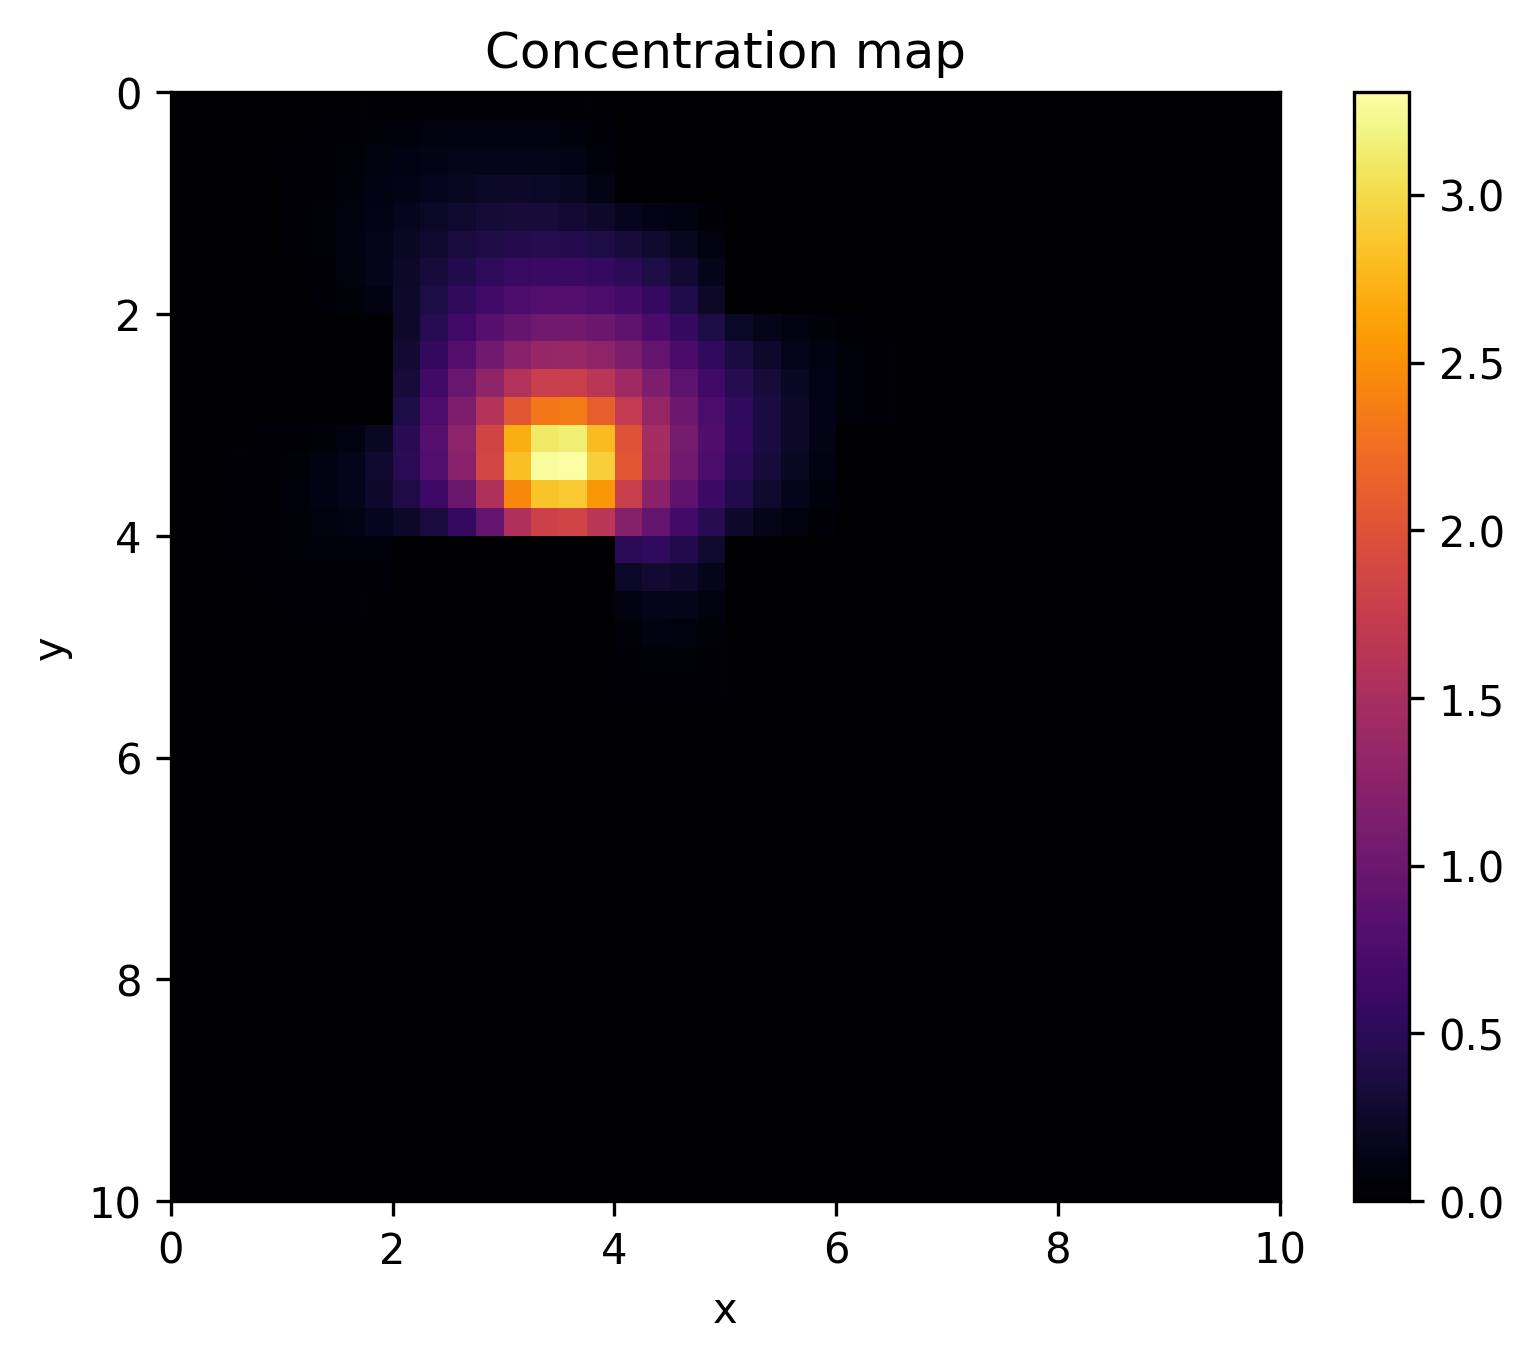

In [22]:
res = 4
ti.init(arch=ti.gpu)

solver = DiffusionSolver(env, resolution=res)
concentration = solver.solve(init_value=100)
fig = vis.Visualizer.plot_2D_field(concentration, add_quiver=False)

As we can see, the concentration decay exponentialy fast in the environment. Therefore, in order to sense variations of the concentration in the environement, it is better to use the log concentration, as observed in chemotactic agents. 

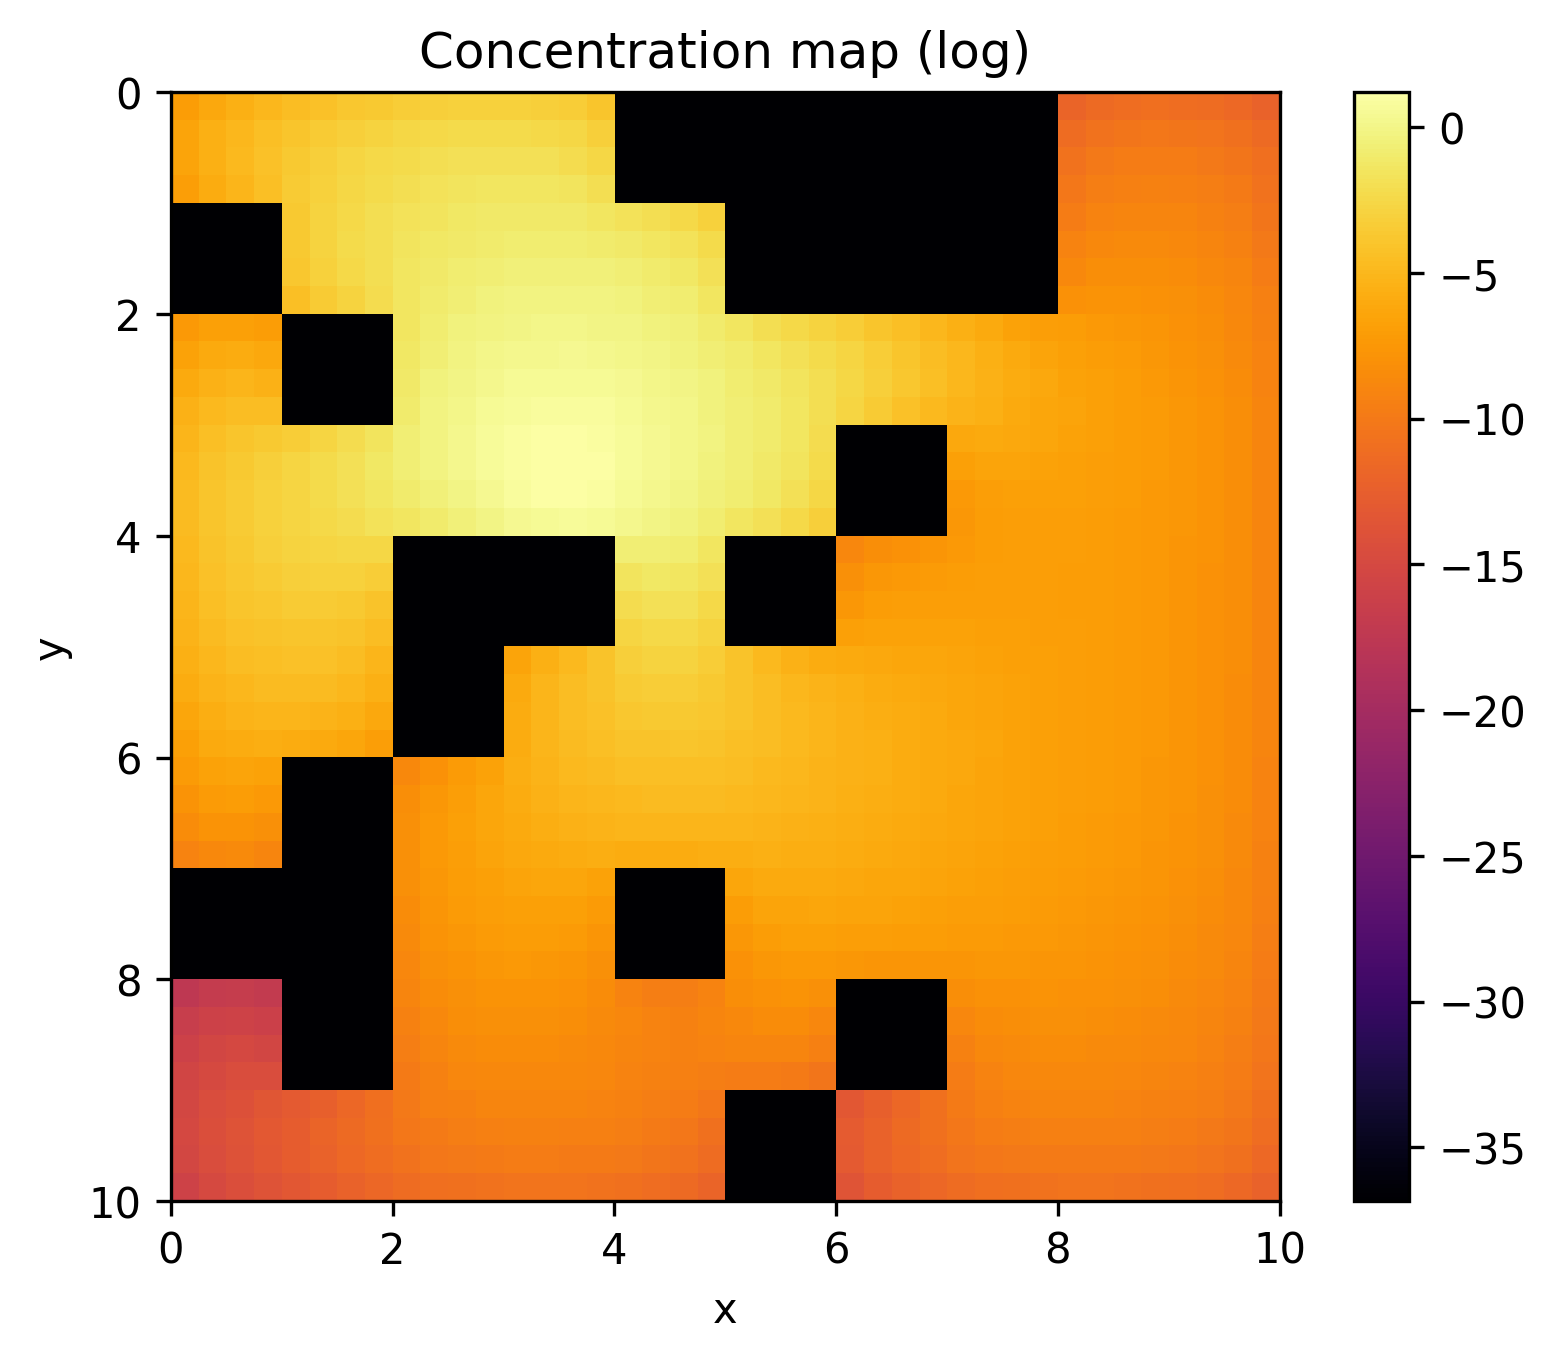

In [23]:
log_concentration = log(concentration, eps=1e-16)
fig = vis.Visualizer.plot_2D_field(log_concentration, title="Concentration map (log)", add_quiver=False)

Once the log concentration is computed, we can estimate the gradient of the scalar field by finite differences in order to define a force field that will guide the robot toward the goal configuration. 

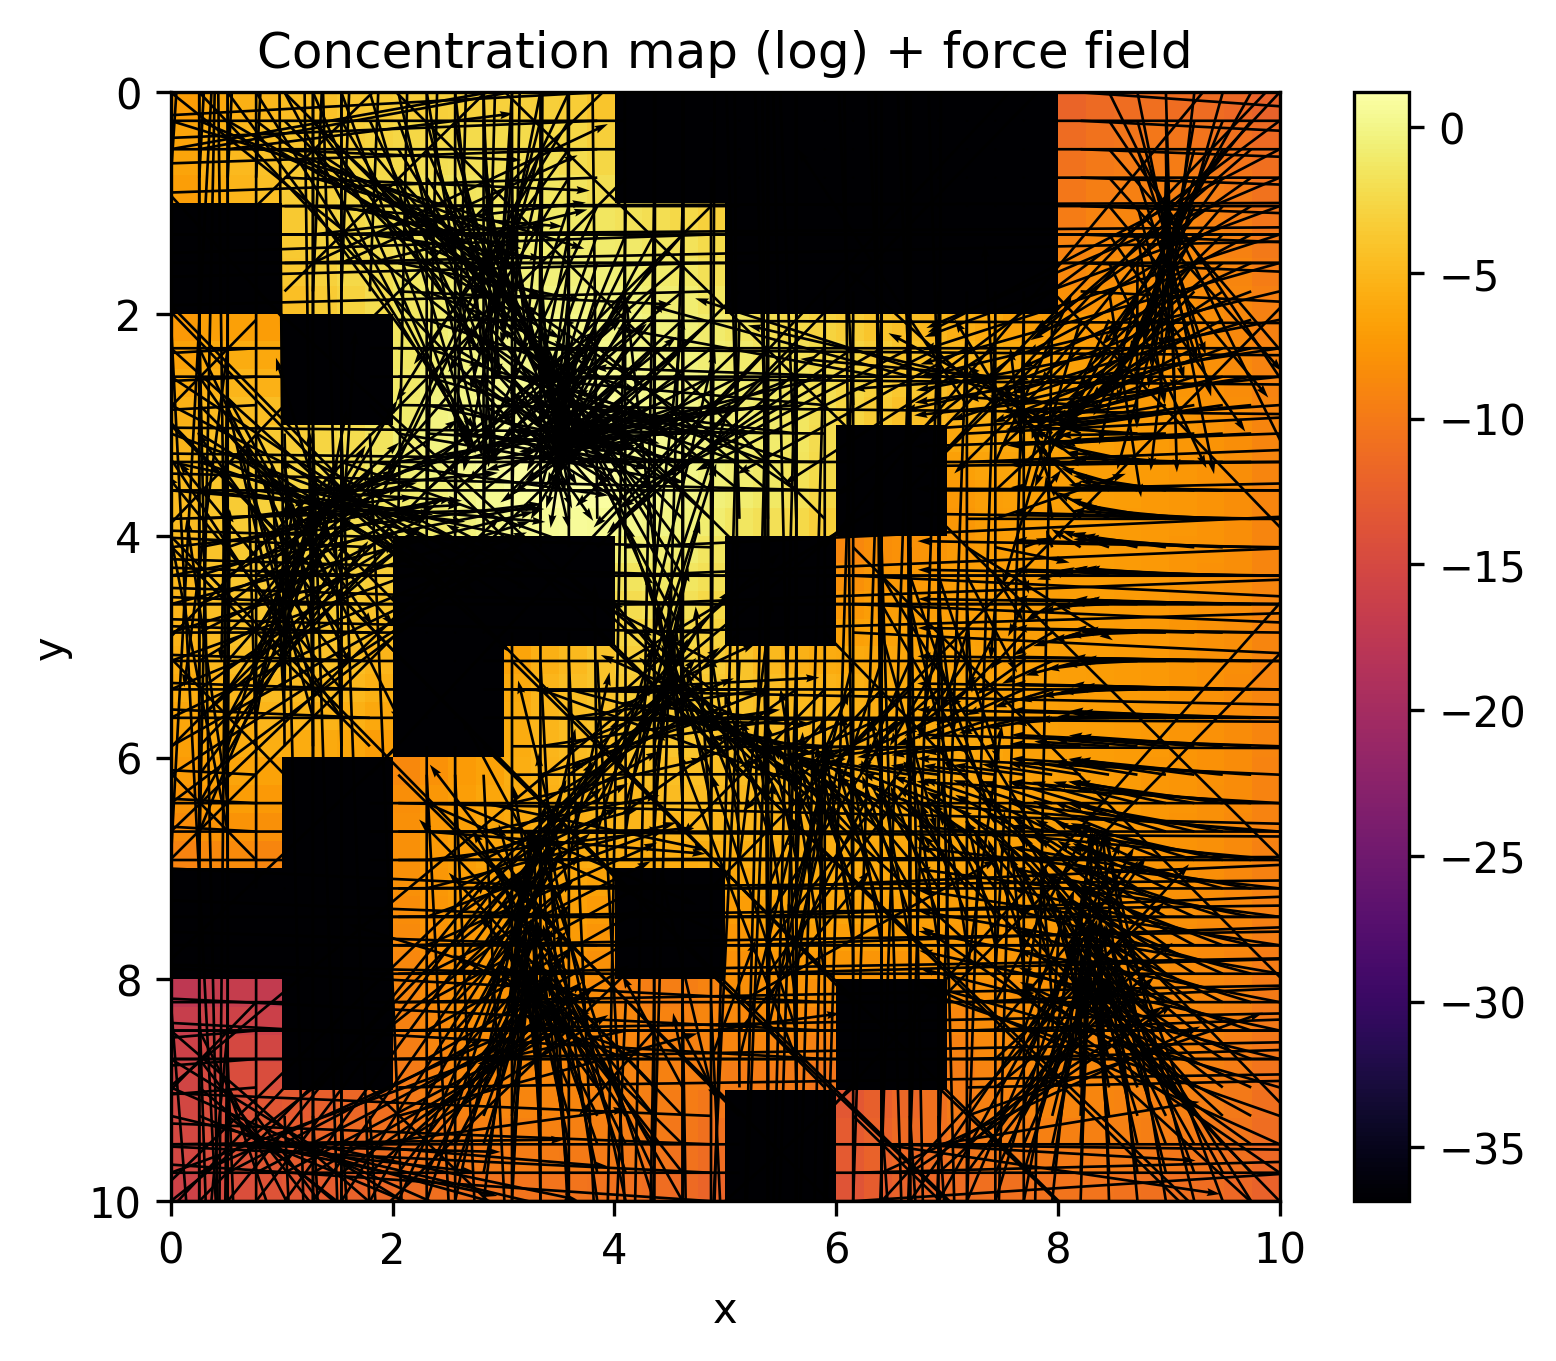

In [24]:
force_field = spatial_gradient(log_concentration)
force_field.clip(1.)
fig = vis.Visualizer.plot_2D_field(log_concentration, title="Concentration map (log) + force field", add_quiver=True)

### Path-planning with differentiable simulation
Finaly, we can solve the path-planning problem by sampling the discretised force field $F$ at each position of the agents with the following update rule : 
$$x_i^{t + 1} = x_i^t + \Delta t\nabla F(x_i^t) + \sigma \sqrt{\Delta t} \epsilon $$ 
with $\Delta t$ the time step of the simulation, $x_i^t$ the position of the *i*-th agent at time *t*, $\sigma$ the diffusion coefficient that control the chemotactic search and $\epsilon \sim \mathcal{N}(0,1)$.

To begin with we can set the diffusion coefficient to 0 in order to see what happens when agents follow a deterministic policy.

In [34]:
t_max, dt = 100, 0.1
sigma = 0

converter = EnvConverter(env, resolution=res)
positions = converter.convert_free_positions_to_point_cloud()
simulation = WalkerSimulationStoch2D(positions, log_concentration, obstacles=env.obstacles, t_max=t_max, dt=dt, diffusivity=sigma)
simulation.reset()
simulation.run()

[W 04/19/24 16:54:54.537 7338] [type_check.cpp:type_check_store@36] [$20049] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
                        ^^^^^^^^^^^^^^^^^^^^^

[W 04/19/24 16:54:54.537 7338] [type_check.cpp:type_check_store@36] [$20072] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
                        ^^^^^^^^^^^^^^^^^^^^^

[W 04/19/24 16:54:54.699 7338] [type_check.cpp:type_check_store@36] [$20440] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
                  

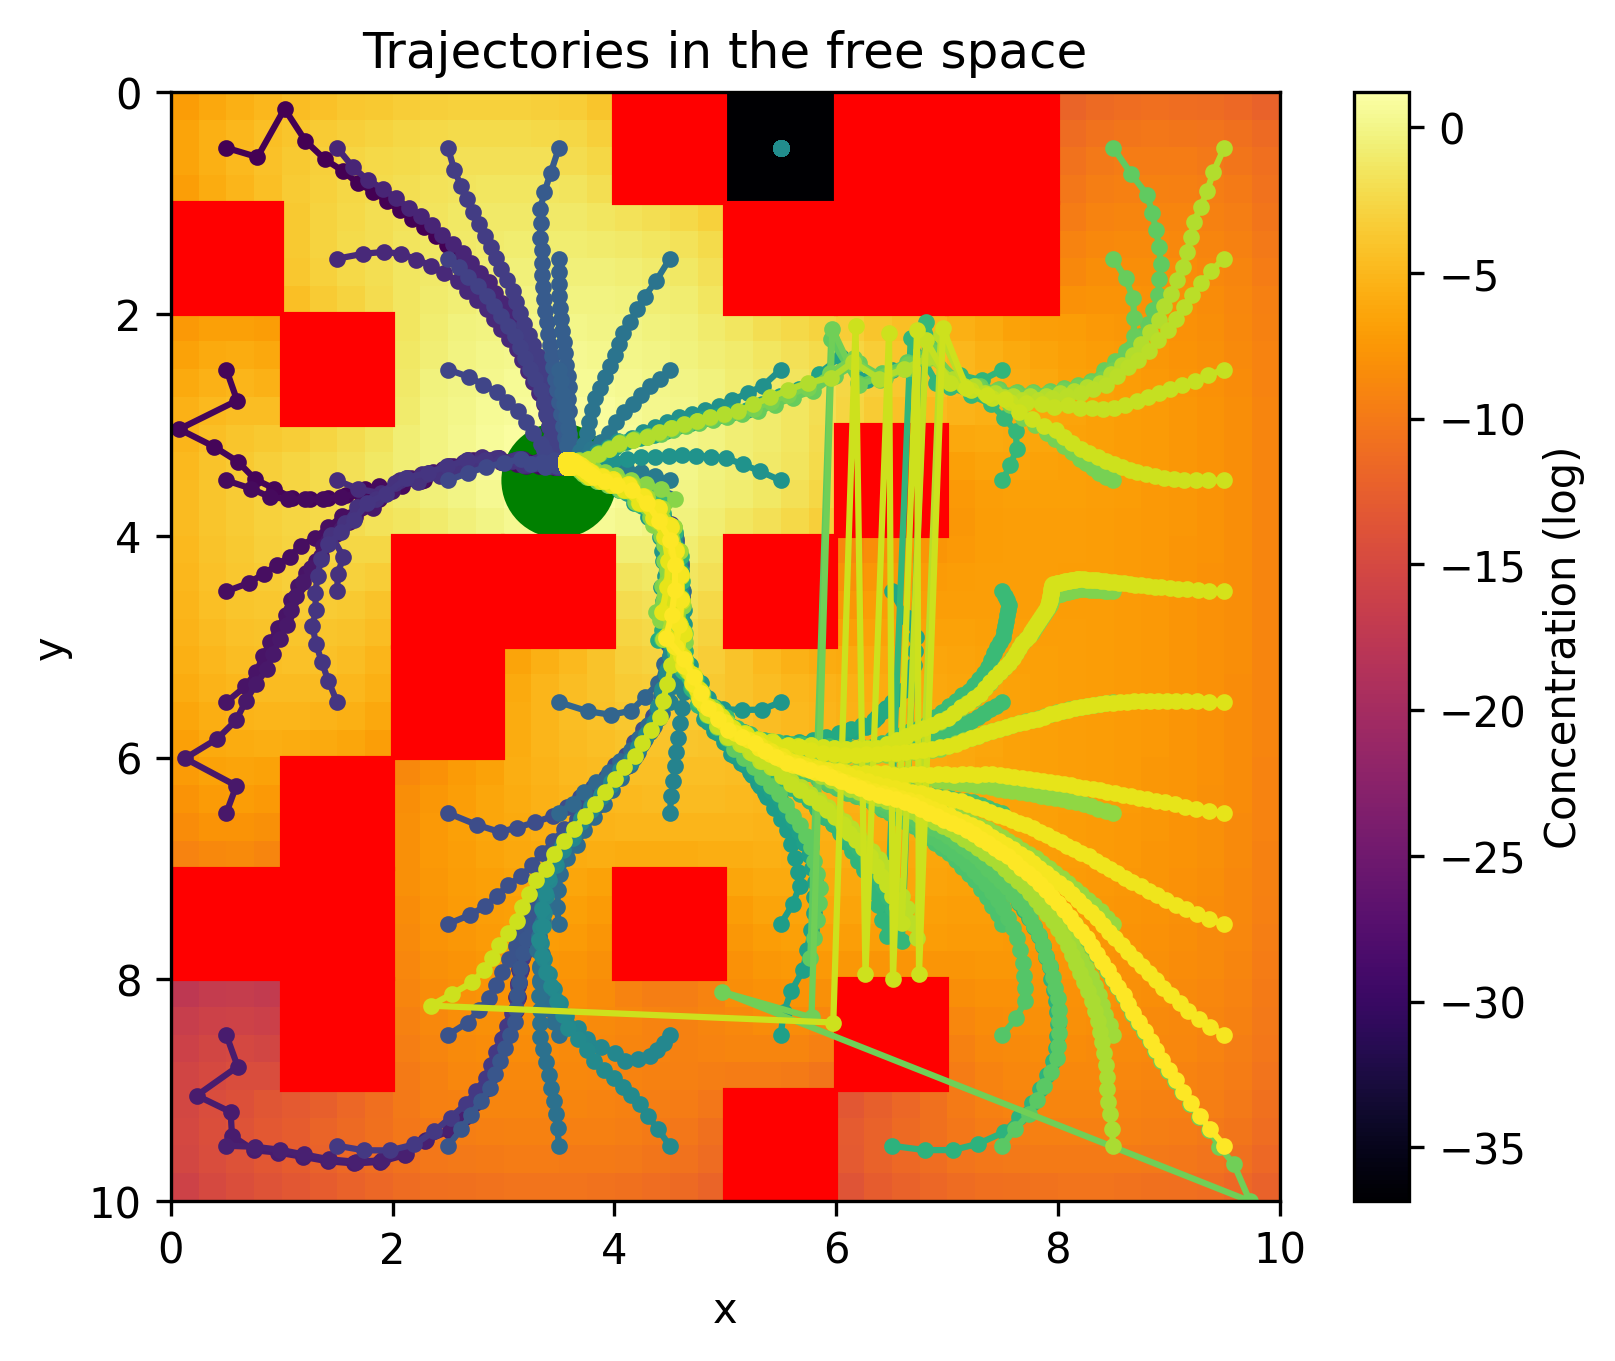

In [35]:
# Plot the result of the simulation
goal_position = converter.get_goal_position()
fig = vis.plot_2D_trajectory(simulation.positions, goal_position, env.obstacles, concentration=log_concentration, title="Trajectories in the free space")

The main oportunity of our approach is to use the auto-differentiation of our simulation to enforce properties we want from the paths we sample.

For example, as we want every path to reach the goal at the end of the simulation, we can define a L2 cost function that measure the distance to the goal at the end of the simulation.
$$\sum_{i=0}^{N-1}\|x_i^T - goal\|_2$$

And as each force field estimation is a linear conbination of the discretized force field, we can make back-propagation of the loss function through the simulation and modify the values of the sampled force field via gradient descent methods. 

In [36]:
# Optimization loop
max_iter = 20
lr = 0.1
simulation.optimize(goal_position, max_iter=max_iter, lr=lr)

Iter= 0 Loss= 0.19646142423152924
Iter= 1 Loss= 0.158762127161026
Iter= 2 Loss= 0.030020281672477722
Iter= 3 Loss= 0.03001653216779232
Iter= 4 Loss= 0.029407694935798645
Iter= 5 Loss= 0.028465889394283295
Iter= 6 Loss= 0.028393398970365524
Iter= 7 Loss= 0.02902972511947155
Iter= 8 Loss= 0.027581937611103058
Iter= 9 Loss= 0.027389008551836014
Iter= 10 Loss= 0.02790991961956024
Iter= 11 Loss= 0.02780058979988098
Iter= 12 Loss= 0.033091459423303604
Iter= 13 Loss= 0.02933472953736782
Iter= 14 Loss= 0.019326305016875267
Iter= 15 Loss= 0.014032220467925072
Iter= 16 Loss= 0.010721207596361637
Iter= 17 Loss= 0.008383962325751781
Iter= 18 Loss= 0.006642235442996025
Iter= 19 Loss= 0.005311532877385616


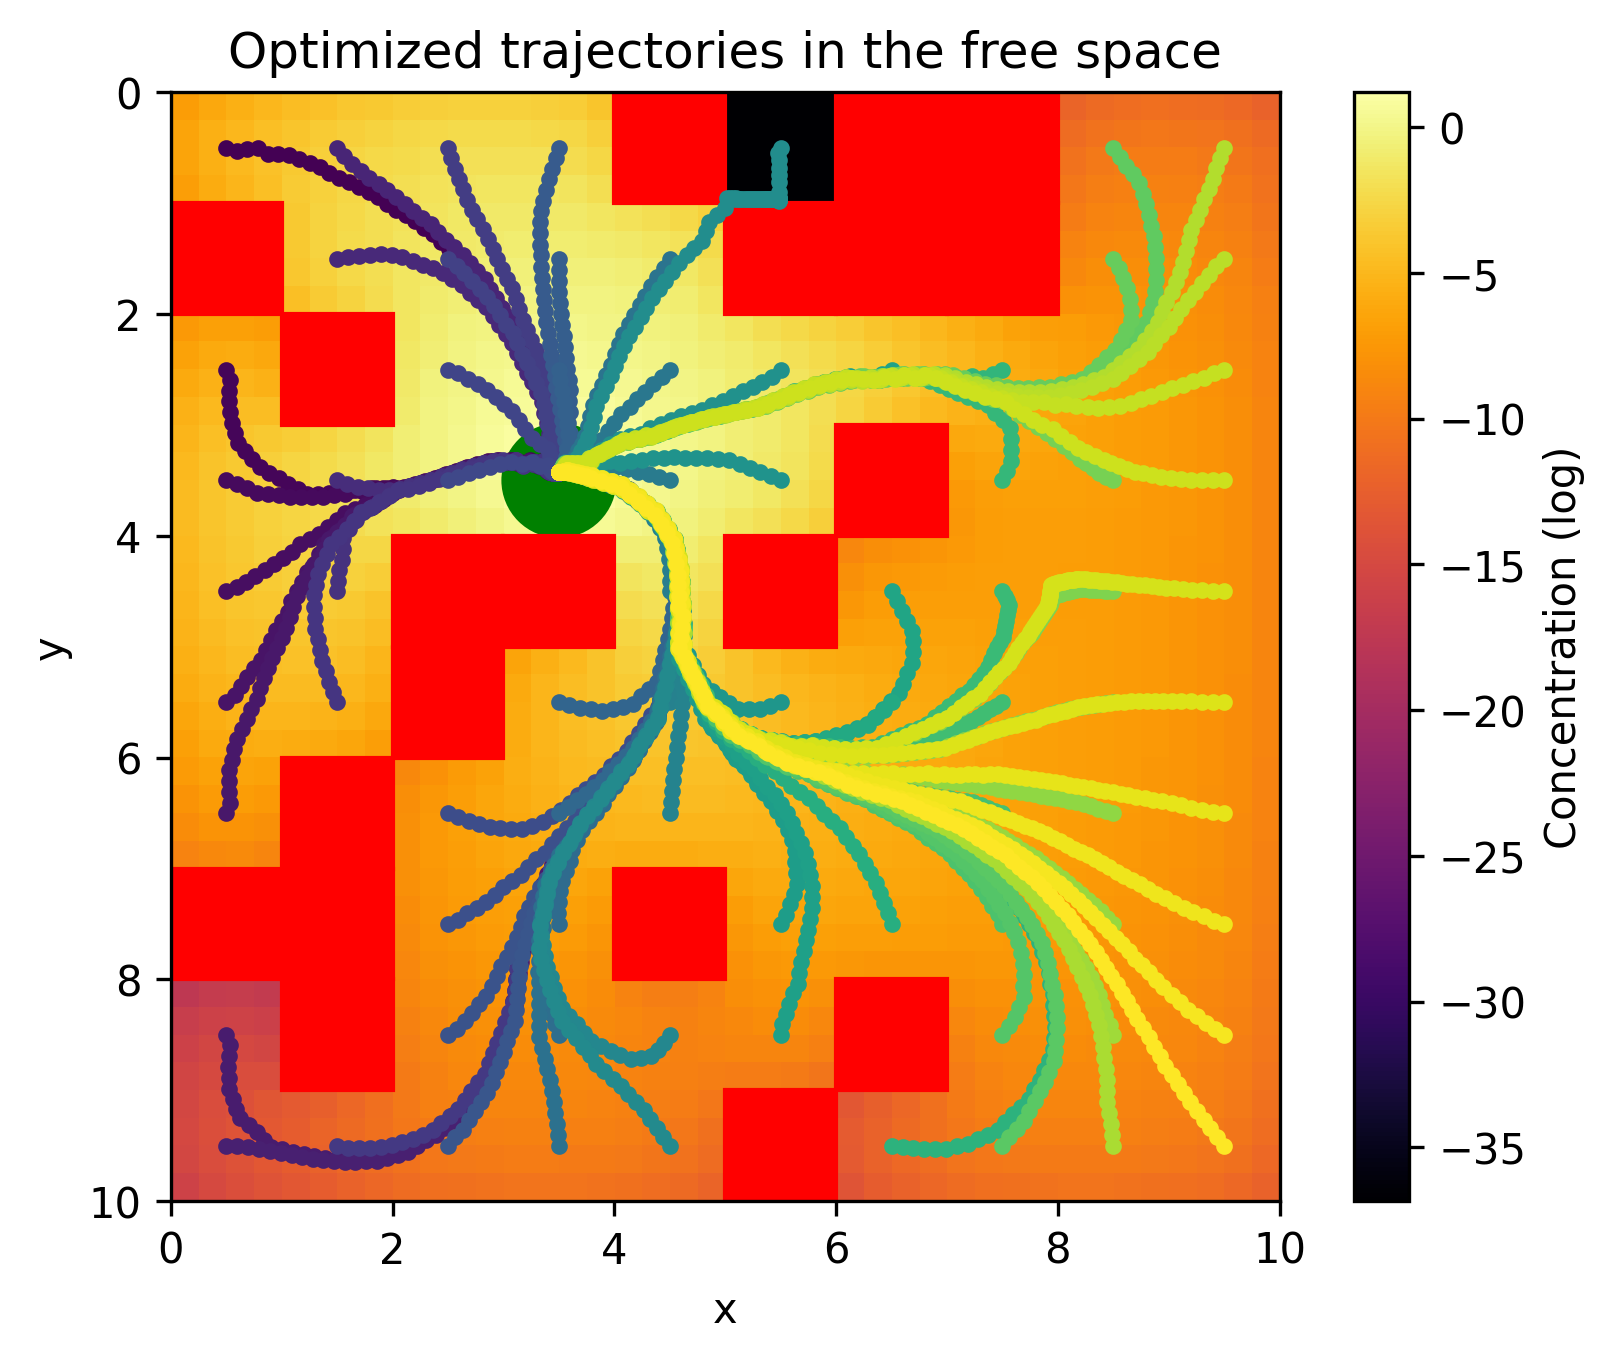

In [28]:
# Visualisation
fig = vis.plot_2D_trajectory(simulation.positions, goal_position, obstacles=env.obstacles, concentration=log_concentration, title="Optimized trajectories in the free space")

### 3D case
Finaly we propose a 3D implementation of our method on a test environement to show its adaptation to higher dimentional problems and to focus on the target medical application.

[Taichi] Starting on arch=cuda


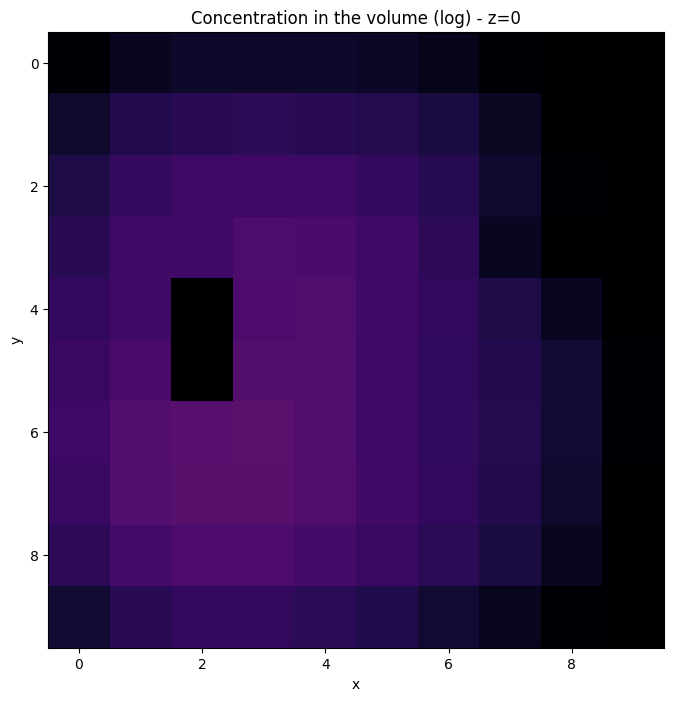

In [50]:
width, height, depth = 10, 10, 10
nb_obs, obs_size = 10, 3 
seed = 25

env_3d = RandomObstacles3D(width, height, depth, nb_obs=nb_obs, max_size=obs_size, seed=seed)
env_3d.reset()

ti.init(arch=ti.gpu)
converter_3d = Env3DConverter(env_3d)
solver = DiffusionSolver(env_3d)

concentration = solver.solve(init_value=100)
log_concentration = log(concentration)
anim = vis.animate_volume(log_concentration.values, title="Concentration in the volume (log)")

This time all the agents will start from the same position in order to show that our method can sample multiple paths in the environement by simply adding noise to the simulation. We set the number of agents to 10 for visualization purpose, but it can be increased with ease.

In [51]:
positions = converter_3d.get_agent_position(repeats=10)
goal_position = converter_3d.get_goal_position()

t_max, dt = 100, 0.1
sigma = 0.01

simulation = WalkerSimulationStoch3D(positions, log_concentration, env_3d.obstacles, t_max=t_max, dt=dt, diffusivity=sigma)
simulation.reset()
simulation.run()

In [47]:
fig = vis.plot_3D_trajectory(simulation.positions, goal_position, obstacles=env_3d.obstacles)
fig.show()

Once again, we can optimize the 3D trajectories sampled from our simulation by using automatic differentiation and gradient descent.

In [52]:
simulation.optimize(goal_position, max_iter=20, lr=0.01)

Iter= 0 Loss= 0.5209046006202698
Iter= 1 Loss= 0.45812854170799255
Iter= 2 Loss= 0.4911877512931824
Iter= 3 Loss= 0.47066158056259155
Iter= 4 Loss= 0.4965404272079468
Iter= 5 Loss= 0.48962825536727905
Iter= 6 Loss= 0.41767215728759766
Iter= 7 Loss= 0.3685481548309326
Iter= 8 Loss= 0.4745359420776367
Iter= 9 Loss= 0.49994027614593506
Iter= 10 Loss= 0.4291582703590393
Iter= 11 Loss= 0.4710206687450409
Iter= 12 Loss= 0.46738117933273315
Iter= 13 Loss= 0.457046777009964
Iter= 14 Loss= 0.48923906683921814
Iter= 15 Loss= 0.4040071964263916
Iter= 16 Loss= 0.476828932762146
Iter= 17 Loss= 0.39337992668151855
Iter= 18 Loss= 0.37203115224838257
Iter= 19 Loss= 0.38884085416793823


In [53]:
fig = vis.plot_3D_trajectory(simulation.positions, goal_position, obstacles=env_3d.obstacles)
fig.show()

We can see that with path optimization, all paths clamp to a main trajectory, which is something we want to avoid. To conserve the multiple path sampling property, we can think about adding a constraint to the cost function that force variation in the sampled trajectories.

## TODO

Here is a list of things to improve / test in the current phase :
- Add bending constraints & multiple path sampling to the cost function
- Introduce 3D geometries of organs to test the method on real data 
- Allow obstacle penetration by computing a cost associated with penetration instead of reflexive conditions
- Amortize the concentration computation by learning the distribution with Physic Informed Neural Networks (PINN)
- Compare with existing path planning methods
- Consider more complex configuration space